# Exercice 9

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def centered_diff(x, t_max, dt, u0_vec, D_mat, c):
    # Initialisation
    dx = x[1] - x[0]
    
    lmb = c*dt/dx
    
    t = np.arange(0, t_max+dt, dt)
    N_t = len(t)
    
    u = np.zeros((N_t, len(u0_vec)))
    u[0, :] = u0_vec

    for n in range(N_t-1):
        if n == 0:  # Premier step : on uilise d u(t, x)/dt|_{t=0} = 0
            # Via diff en aval d'ordre 2
            # with u'(0, x) = 0.5*(-1.0+x)**2 * x**2 * (-1.0+2*x)
            # u[n+1, :] = u[n, :] + dt * 0.5*(-1.0+x)**2 * x**2 * (-1.0+2*x)
            A = 2*np.eye(len(u0_vec)) - lmb**2 * D_mat
            u[n+1, :] = np.linalg.solve(A, 2*dt*0.5*(-1.0+x)**2 * x**2 * (-1.0+2*x) + 2*u[n, :])
        else:
            u[n+1, :] = 2*u[n, :] + lmb**2 * D_mat @ u[n, :] - u[n-1, :]

        # Conditions aux bords de Neumann
        # Différences finies en aval u'[0] = (-3u[0] + 4u[1] - u[2])/(2dx)
        # => u[0] = (4u[1] - u[2] - 2dx*u'[0])/3
        u[n+1, 0] = (4*u[n+1, 1] - u[n+1, 2])/3.0
        # Différences finies en amont u'[-1] = (3u[-1] - 4u[-2] + u[-3])/(2dx)
        # => u[-1] = (4u[-2] - u[-3] + 2dx*u'[-1])/3
        u[n+1, -1] = (4*u[n+1, -2] - u[n+1, -3])/3.0

    return t, u

# Solution analytique


def u_exact(t_vec):
    x = np.linspace(0, 1, 10)
    u = np.zeros((len(t_vec), len(x)))

    for (i, t) in enumerate(t_vec):
        if t == 0:
            u[i, :] = (x-1.5) * x**2 + 0.25
            continue
        for k in range(0, 20):
            ui = (12*np.sqrt(2)*np.cos((1 + 2*k)*np.pi*x)*(np.sqrt(2)*(np.pi + 2*k*np.pi)**3*np.cos(((1 + 2*k)*np.pi*t)/np.sqrt(10)
                                                                                                    ) + 4*np.sqrt(5)*(-10 + (np.pi + 2*k*np.pi)**2)*np.sin(((1 + 2*k)*np.pi*t)/np.sqrt(10))))/(np.pi + 2*k*np.pi)**7
            u[i, :] += ui

    return x, u

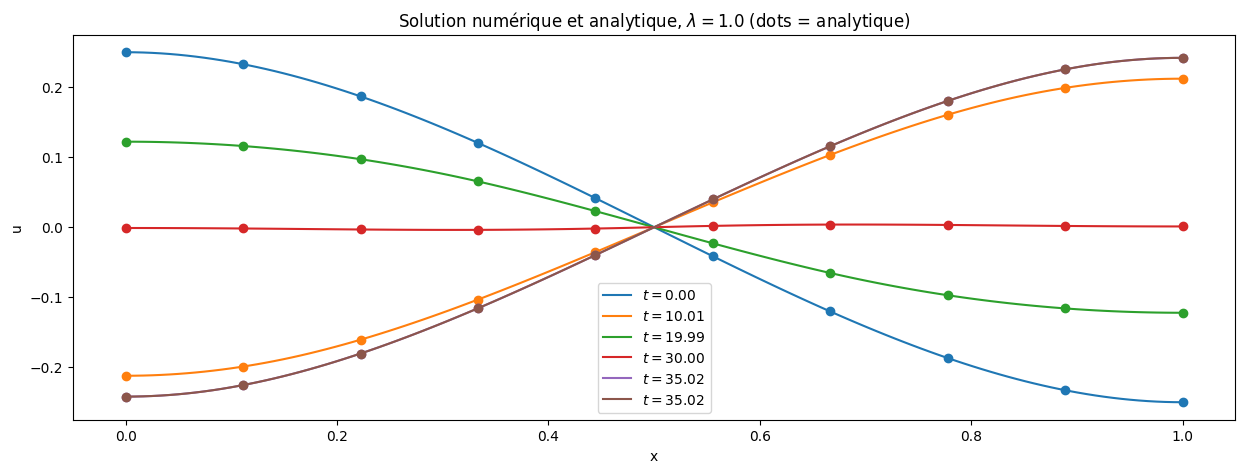

In [2]:
N = 120
t_max = 35.0

x = np.linspace(0, 1, N+2) # on s'assure que les points de bord sont inclus
dx = x[1] - x[0]

# Condition CFL de stabilité : lmb <= 1.0
lmb = 1.0 # Il y a peu de même avec 0.01 dispersion car le problème est stable et que les condition de Neumann sont "correctrices"
c = np.sqrt(1.0/10.0)
dt = lmb * dx / c

u0_vec = (x-1.5)* x**2 + 0.25

D = np.zeros((N+2, N+2))
for i in range(1, N+1):
    D[i, i-1] = 1.0
    D[i, i] = -2.0
    D[i, i+1] = 1.0
    
t, u_num = centered_diff(x, t_max, dt, u0_vec, D, c)
x_analytic, u_analytic = u_exact(t)

fig, ax = plt.subplots(figsize=(15, 5))

t_sol = [0.0, 10.0, 20.0, 30.0, 40.0, 50]

# ax.plot(x, u0_vec, 'k--', label="Conition initiale")
for (i, t_val) in enumerate(t_sol):
    # On cherche l'indice le plus proche
    n = np.argmin(np.abs(t-t_val))
    ax.plot(x, u_num[n, :], label=f"$t = {t[n]:.2f}$", color = f'C{i}')
    ax.plot(x_analytic, u_analytic[n, :], 'o', color = f'C{i}')
    
ax.set_xlabel("x")
ax.set_ylabel("u")
ax.set_title(f"Solution numérique et analytique, $\lambda={lmb}$ (dots = analytique)")
ax.legend()
plt.show()

In [3]:
%%capture
# Création d'un GIF
from matplotlib.animation import FuncAnimation

fig_anim, ax_anim = plt.subplots(figsize=(15, 5))

line, = ax_anim.plot([], [])

# Init
ax_anim.set_xlim(x[0], x[-1])
ax_anim.set_ylim(np.min(u_num)-0.05, np.max(u_num)+0.05)

ax_anim.set_xlabel("x")
ax_anim.set_ylabel("u")
# ax_anim.set_title(f"Wave Animation, $\lambda={lmb}$")


def animate(i):
    line.set_data(x, u_num[3*i, :])
    ax_anim.set_title(f"Wave Animation, $\lambda={lmb}$, t = {t[3*i]:.2f}")
    return line,

# Create the animation
anim = FuncAnimation(fig_anim, animate, frames=len(t)//3, blit=True, repeat=True);

# Save the animation as an MP4 file
anim.save('wave_animation.mp4', writer='ffmpeg', fps=len(t)//(3*25));


In [4]:
%reset -f

# Exercice 10

## Solution

En utilisant des différences centrées d'ordre 2:

$$
\begin{align*}
    \frac{u^{n+1}_{i} -2u^{n}_{i} + u^{n-1}_{i}}{\Delta t^2} + b \frac{u^{n+1}_{i}-u^{n-1}_{i}}{2\Delta t} - c^2 \frac{u^{n}_{i+1} -2u^{n}_{i} + u^{n}_{i-1}}{\Delta x^2}=0\\
    \Rightarrow u^{n+1}_i = \frac{2 c^2
   \Delta t^2 u^{n}_{i+1}+4
   \left(\Delta x^2-c^2 \Delta t^2\right)
   u^{n}_i+2 c^2 \Delta t^2 u^{n}_{i-1}}{\Delta x^2 (b
   \Delta t+2)} + \frac{b\Delta t - 2}{b\Delta t + 2}u^{n-1}_i
\end{align*}
$$

CFL : todo
(partir d'une forme générale $\epsilon^{n+1}_i = \alpha \epsilon^{n}_{i+1} + \beta \epsilon^{n}_i + \gamma \epsilon^{n}_{i-1} + \delta \epsilon^{n-1}_i$)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def centered_diff(x, t_max, dt, u0_vec, b, c):
    dx = x[1] - x[0]
    
    D_mat = np.zeros((len(u0_vec), len(u0_vec)))
    s = 2*c**2*dt**2 / (dx**2 * (b*dt + 2))
    d = 4*(dx**2 - c**2*dt**2) / (dx**2 * (b*dt + 2))
    for i in range(1, len(u0_vec)-1):
        D_mat[i, i-1] = s
        D_mat[i, i] = d
        D_mat[i, i+1] = s
        
    # Domaine infini -> on peut négliger les points 0 et N+1 qui sont supposé être constants et égaux à 0
    t = np.arange(0, t_max+dt, dt)
    N_t = len(t)
    
    u = np.zeros((N_t, len(u0_vec)))
    u[0, :] = u0_vec
    u[1, :] = u0_vec # On utilise la condition u'(0, x) = 0
    
    f = (b*dt - 2)/(b*dt + 2)
    for n in range(1, N_t-1):
        u[n+1, :] = D_mat @ u[n, :] + f*u[n-1, :]
        
    return t, u

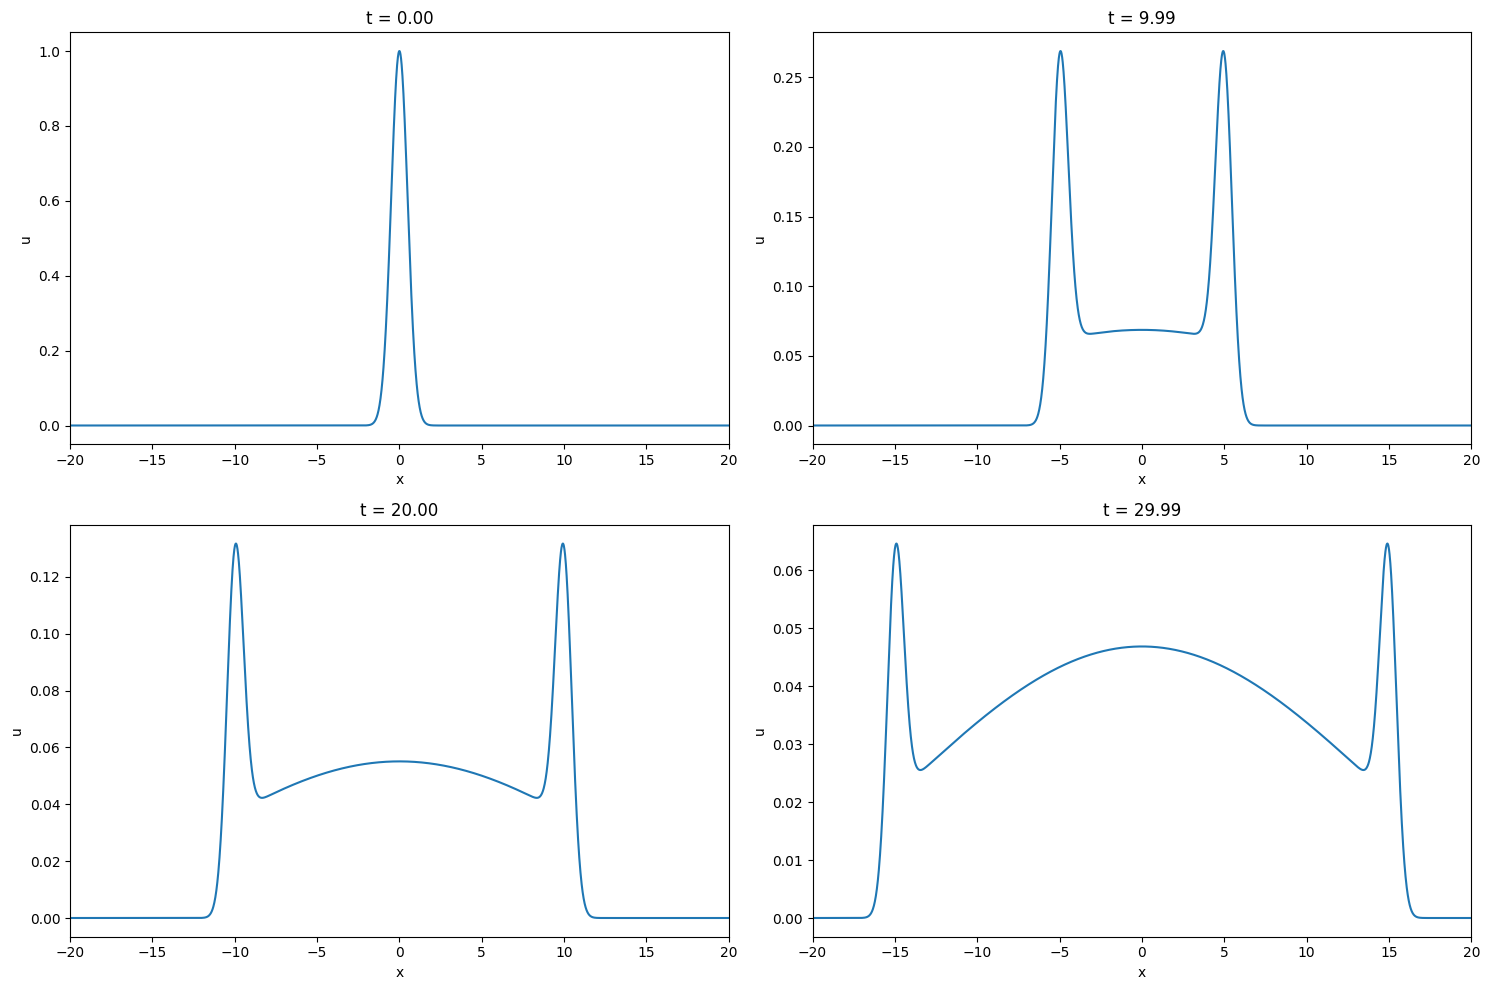

In [6]:
N = 5000
t_max = 30.0
x_max = 30.0

b = 0.15
c = np.sqrt(1.0/4.0)

x = np.linspace(-x_max, x_max, N+2)
u0_vec = np.exp(-2*x**2)

dt = (x[1] - x[0])/c * 0.5

t, u_num = centered_diff(x, t_max, dt, u0_vec, b, c)
# It does not have a simple analytical solution :(
    
fig, ax = plt.subplots(2,2, figsize=(15, 10))

i_t00 = 0
i_t10 = np.argmin(np.abs(t-10.0))
i_t20 = np.argmin(np.abs(t-20.0))
i_t30 = np.argmin(np.abs(t-30.0))

ax[0, 0].plot(x, u_num[i_t00, :])
ax[0, 0].set_title(f"t = {t[i_t00]:.2f}")
ax[0, 1].plot(x, u_num[i_t10, :])
ax[0, 1].set_title(f"t = {t[i_t10]:.2f}")
ax[1, 0].plot(x, u_num[i_t20, :])
ax[1, 0].set_title(f"t = {t[i_t20]:.2f}")
ax[1, 1].plot(x, u_num[i_t30, :])
ax[1, 1].set_title(f"t = {t[i_t30]:.2f}")

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlim(-20.0, 20.0)
        ax[i, j].set_xlabel("x")
        ax[i, j].set_ylabel("u")
        
plt.tight_layout()
plt.show()

# The solution as been checked against a completly different solver and is OK.


In [7]:
%%capture
# Création d'un GIF
from matplotlib.animation import FuncAnimation

fig_anim, ax_anim = plt.subplots(figsize=(15, 5))

line, = ax_anim.plot([], [])

# Init
ax_anim.set_xlim(-20.0, 20.0)
ax_anim.set_ylim(np.min(u_num)-0.05, np.max(u_num)+0.05)

ax_anim.set_xlabel("x")
ax_anim.set_ylabel("u")
# ax_anim.set_title(f"Damped Wave Animation")

def animate(i):
    line.set_data(x, u_num[3*i, :])
    ax_anim.set_title(f"Damped Wave Animation, t = {t[3*i]:.2f}")
    return line,

# Create the animation
anim = FuncAnimation(fig_anim, animate, frames=len(t)//3, blit=True, repeat=True);

# Save the animation as an MP4 file
anim.save('damped_wave_animation.mp4', writer='ffmpeg', fps=len(t)//(3*25));


In [8]:
%reset -f